1]. Problem Statement: Lane Detection and Segmentation

2]. Objective:
Implement an ENet architecture for lane detection and segmentation using deep learning techniques. The model should accurately predict binary segmentation masks and instance embeddings for lanes in urban scenes.

3]. Details:

Dataset: Utilize the TuSimple dataset for training and evaluation, containing images and corresponding lane annotations in JSON format.

Model Architecture: Implement the ENet architecture comprising:
        InitialBlock for initial feature extraction.
        Multiple DownsamplingBottleneck and RegularBottleneck blocks for hierarchical feature extraction.
        Separate branches for binary segmentation and instance embedding prediction using UpsamplingBottleneck blocks.

Loss Functions:
        Binary Segmentation: Cross-entropy loss.
        Instance Embedding: Custom Discriminative Loss, incorporating variance, distance, and regularization components to enhance instance embedding quality.

Training: Train the model using stochastic gradient descent (SGD) with momentum.

Evaluation: Evaluate the model on a separate evaluation set using standard metrics for lane detection and segmentation tasks.

7]. Expected Output: Trained model capable of accurate lane detection and segmentation in urban driving scenarios, suitable for real-time applications.

In [1]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import tqdm

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/Users/dakshpatel/Desktop/Computer_Vision/Project/Code/TuSimple_Dataset/TUSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h


        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))
                
                

class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)


class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)


class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits
    
class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue 
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)
    
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cuda")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

# Define your LaneDataset class, ENet model, DiscriminativeLoss, and compute_loss as provided earlier

# Constants for training
BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 32

# Create the training dataset and dataloader
train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the ENet model and move it to the GPU device
enet_model = ENet(2, 4)
enet_model.to(device)

# Define the optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# Create a directory for logs
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Set up TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Lists to store losses and accuracies
binary_losses_epoch = []
instance_losses_epoch = []
train_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    correct_binary = 0
    total_pixels = 0
    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

        binary_preds = torch.argmax(binary_logits, dim=1)
        correct_binary += torch.sum(binary_preds == binary_target).item()
        total_pixels += binary_target.numel()

    binary_accuracy = correct_binary / total_pixels
    train_accuracies.append(binary_accuracy)

    mean_losses = np.array(losses).mean(axis=0)
    binary_losses_epoch.append(mean_losses[0])
    instance_losses_epoch.append(mean_losses[1])

    # Log metrics to TensorBoard
    writer.add_scalar("Binary Loss", mean_losses[0], epoch)
    writer.add_scalar("Instance Loss", mean_losses[1], epoch)
    writer.add_scalar("Binary Accuracy", binary_accuracy, epoch)

    # Log details of all layers in histogram format
    for name, param in enet_model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=epoch)

    # Print and save results for this epoch
    msg = (f"Epoch {epoch}:"
          f" Binary Loss = {mean_losses[0]:.4f}, Instance Loss = {mean_losses[1]:.4f}, Binary Accuracy = {binary_accuracy:.4f}")
    print(msg)

# Close TensorBoard writer
writer.close()

In [7]:
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import tqdm

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/Users/dakshpatel/Desktop/Computer_Vision/Project/Code/TuSimple_Dataset/TUSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h

        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            cv2.polylines(image, [lane], False, color, 10)

        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))

class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)

class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices

class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

class DiscriminativeLoss(_Loss):
    def __init__(self, delta_var=0.5, delta_dist=3,
                 norm=2, alpha=1.0, beta=1.0, gamma=0.001,
                 device="cpu", reduction="mean", n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        assert not target.requires_grad

        return self._discriminative_loss(input, target)

    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss=torch.tensor(0.).to(self.device)
        var_loss=torch.tensor(0.).to(self.device)
        reg_loss=torch.tensor(0.).to(self.device)
        for i in range(num_samples):
            clusters=[]
            sample_embedding=input[i,:,:,:]
            sample_label=target[i,:,:].squeeze()
            num_clusters=len(sample_label.unique())-1
            vals=sample_label.unique()[1:]
            sample_label=sample_label.view(sample_label.size(0)*sample_label.size(1))
            sample_embedding=sample_embedding.view(-1,sample_embedding.size(1)*sample_embedding.size(2))
            v_loss=torch.tensor(0.).to(self.device)
            d_loss=torch.tensor(0.).to(self.device)
            r_loss=torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices=(sample_label==vals[j]).nonzero()
                indices=indices.squeeze()
                cluster_elements=torch.index_select(sample_embedding,1,indices)
                Nc=cluster_elements.size(1)
                mean_cluster=cluster_elements.mean(dim=1,keepdim=True)
                clusters.append(mean_cluster)
                v_loss+=torch.pow((torch.clamp(torch.norm(cluster_elements-mean_cluster)-self.delta_var,min=0.)),2).sum()/Nc
                r_loss+=torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx,cluster in enumerate(clusters):
                    if index==idx:
                        continue 
                    else:
                        distance=torch.norm(clusters[index]-cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss+=torch.pow(torch.clamp(self.delta_dist-distance,min=0.),2)
            var_loss+=v_loss/num_clusters
            dis_loss+=d_loss/(num_clusters*(num_clusters-1))
            reg_loss+=r_loss/num_clusters
        return self.alpha*(var_loss/num_samples)+self.beta*(dis_loss/num_samples)+self.gamma*(reg_loss/num_samples)

def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device="cpu")
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

# Constants for training
BATCH_SIZE = 8
LR = 5e-4
NUM_EPOCHS = 32

# Create the training dataset and dataloader
train_dataset = LaneDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cpu")

# Create the ENet model and move it to the CPU device
enet_model = ENet(2, 4)
enet_model.to(device)

# Define the optimizer
params = [p for p in enet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=LR, weight_decay=0.0002)

# Create a directory for logs
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Set up TensorBoard writer
writer = SummaryWriter(log_dir=log_dir)

# Lists to store losses and accuracies
binary_losses_epoch = []
instance_losses_epoch = []
train_accuracies = []

# Training loop
for epoch in range(NUM_EPOCHS):
    enet_model.train()
    losses = []
    correct_binary = 0
    total_pixels = 0
    for batch in tqdm.tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)

        optimizer.zero_grad()

        binary_logits, instance_emb = enet_model(img)

        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()

        optimizer.step()

        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))

        binary_preds = torch.argmax(binary_logits, dim=1)
        correct_binary += torch.sum(binary_preds == binary_target).item()
        total_pixels += binary_target.numel()

    binary_accuracy = correct_binary / total_pixels
    train_accuracies.append(binary_accuracy)

    mean_losses = np.array(losses).mean(axis=0)
    binary_losses_epoch.append(mean_losses[0])
    instance_losses_epoch.append(mean_losses[1])

    # Log metrics to TensorBoard
    writer.add_scalar("Binary Loss", mean_losses[0], epoch)
    writer.add_scalar("Instance Loss", mean_losses[1], epoch)
    writer.add_scalar("Binary Accuracy", binary_accuracy, epoch)

    # Log details of all layers in histogram format
    for name, param in enet_model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), global_step=epoch)

    # Print and save results for this epoch
    msg = (f"Epoch {epoch}:"
          f" Binary Loss = {mean_losses[0]:.4f}, Instance Loss = {mean_losses[1]:.4f}, Binary Accuracy = {binary_accuracy:.4f}")
    print(msg)

# Close TensorBoard writer
writer.close()


100%|█████████████████████████████████████████| 402/402 [26:25<00:00,  3.94s/it]


Epoch 0: Binary Loss = 0.1254, Instance Loss = 2.1590, Binary Accuracy = 0.9653


100%|█████████████████████████████████████████| 402/402 [24:09<00:00,  3.61s/it]


Epoch 1: Binary Loss = 0.0597, Instance Loss = 0.5233, Binary Accuracy = 0.9733


100%|█████████████████████████████████████████| 402/402 [24:41<00:00,  3.68s/it]


Epoch 2: Binary Loss = 0.0521, Instance Loss = 0.3609, Binary Accuracy = 0.9733


100%|█████████████████████████████████████████| 402/402 [24:43<00:00,  3.69s/it]


Epoch 3: Binary Loss = 0.0495, Instance Loss = 0.2709, Binary Accuracy = 0.9734


100%|█████████████████████████████████████████| 402/402 [39:12<00:00,  5.85s/it]


Epoch 4: Binary Loss = 0.0489, Instance Loss = 0.2319, Binary Accuracy = 0.9733


100%|█████████████████████████████████████████| 402/402 [50:45<00:00,  7.57s/it]


Epoch 5: Binary Loss = 0.0472, Instance Loss = 0.1330, Binary Accuracy = 0.9733


100%|█████████████████████████████████████████| 402/402 [31:25<00:00,  4.69s/it]


Epoch 6: Binary Loss = 0.0468, Instance Loss = 0.1093, Binary Accuracy = 0.9732


100%|█████████████████████████████████████████| 402/402 [26:04<00:00,  3.89s/it]


Epoch 7: Binary Loss = 0.0461, Instance Loss = 0.0749, Binary Accuracy = 0.9732


100%|█████████████████████████████████████████| 402/402 [25:02<00:00,  3.74s/it]


Epoch 8: Binary Loss = 0.0455, Instance Loss = 0.0566, Binary Accuracy = 0.9731


100%|█████████████████████████████████████████| 402/402 [41:54<00:00,  6.25s/it]


Epoch 9: Binary Loss = 0.0454, Instance Loss = 0.0601, Binary Accuracy = 0.9732


100%|█████████████████████████████████████████| 402/402 [42:53<00:00,  6.40s/it]


Epoch 10: Binary Loss = 0.0450, Instance Loss = 0.0503, Binary Accuracy = 0.9732


100%|█████████████████████████████████████████| 402/402 [45:47<00:00,  6.83s/it]


Epoch 11: Binary Loss = 0.0444, Instance Loss = 0.0421, Binary Accuracy = 0.9732


100%|█████████████████████████████████████████| 402/402 [50:24<00:00,  7.52s/it]


Epoch 12: Binary Loss = 0.0441, Instance Loss = 0.0385, Binary Accuracy = 0.9733


100%|█████████████████████████████████████████| 402/402 [39:01<00:00,  5.82s/it]


Epoch 13: Binary Loss = 0.0441, Instance Loss = 0.0382, Binary Accuracy = 0.9735


100%|█████████████████████████████████████████| 402/402 [39:29<00:00,  5.90s/it]


Epoch 14: Binary Loss = 0.0440, Instance Loss = 0.0411, Binary Accuracy = 0.9739


100%|█████████████████████████████████████████| 402/402 [36:21<00:00,  5.43s/it]


Epoch 15: Binary Loss = 0.0441, Instance Loss = 0.0478, Binary Accuracy = 0.9741


100%|█████████████████████████████████████████| 402/402 [37:55<00:00,  5.66s/it]


Epoch 16: Binary Loss = 0.0438, Instance Loss = 0.0428, Binary Accuracy = 0.9744


100%|█████████████████████████████████████████| 402/402 [29:04<00:00,  4.34s/it]


Epoch 17: Binary Loss = 0.0436, Instance Loss = 0.0378, Binary Accuracy = 0.9747


100%|█████████████████████████████████████████| 402/402 [23:51<00:00,  3.56s/it]


Epoch 18: Binary Loss = 0.0436, Instance Loss = 0.0399, Binary Accuracy = 0.9752


100%|█████████████████████████████████████████| 402/402 [24:48<00:00,  3.70s/it]


Epoch 19: Binary Loss = 0.0432, Instance Loss = 0.0349, Binary Accuracy = 0.9760


100%|█████████████████████████████████████████| 402/402 [25:39<00:00,  3.83s/it]


Epoch 20: Binary Loss = 0.0419, Instance Loss = 0.0340, Binary Accuracy = 0.9801


100%|█████████████████████████████████████████| 402/402 [25:54<00:00,  3.87s/it]


Epoch 21: Binary Loss = 0.0406, Instance Loss = 0.0321, Binary Accuracy = 0.9823


100%|█████████████████████████████████████████| 402/402 [26:03<00:00,  3.89s/it]


Epoch 22: Binary Loss = 0.0398, Instance Loss = 0.0296, Binary Accuracy = 0.9826


100%|█████████████████████████████████████████| 402/402 [27:10<00:00,  4.06s/it]


Epoch 23: Binary Loss = 0.0398, Instance Loss = 0.0332, Binary Accuracy = 0.9827


100%|█████████████████████████████████████████| 402/402 [28:29<00:00,  4.25s/it]


Epoch 24: Binary Loss = 0.0391, Instance Loss = 0.0261, Binary Accuracy = 0.9829


100%|█████████████████████████████████████████| 402/402 [29:01<00:00,  4.33s/it]


Epoch 25: Binary Loss = 0.0390, Instance Loss = 0.0256, Binary Accuracy = 0.9830


100%|█████████████████████████████████████████| 402/402 [29:56<00:00,  4.47s/it]


Epoch 26: Binary Loss = 0.0390, Instance Loss = 0.0288, Binary Accuracy = 0.9829


100%|█████████████████████████████████████████| 402/402 [30:44<00:00,  4.59s/it]


Epoch 27: Binary Loss = 0.0390, Instance Loss = 0.0298, Binary Accuracy = 0.9830


100%|█████████████████████████████████████████| 402/402 [31:43<00:00,  4.74s/it]


Epoch 28: Binary Loss = 0.0390, Instance Loss = 0.0278, Binary Accuracy = 0.9830


100%|█████████████████████████████████████████| 402/402 [32:19<00:00,  4.82s/it]


Epoch 29: Binary Loss = 0.0385, Instance Loss = 0.0237, Binary Accuracy = 0.9832


100%|█████████████████████████████████████████| 402/402 [32:43<00:00,  4.88s/it]


Epoch 30: Binary Loss = 0.0384, Instance Loss = 0.0250, Binary Accuracy = 0.9833


100%|█████████████████████████████████████████| 402/402 [33:23<00:00,  4.98s/it]


Epoch 31: Binary Loss = 0.0382, Instance Loss = 0.0207, Binary Accuracy = 0.9833


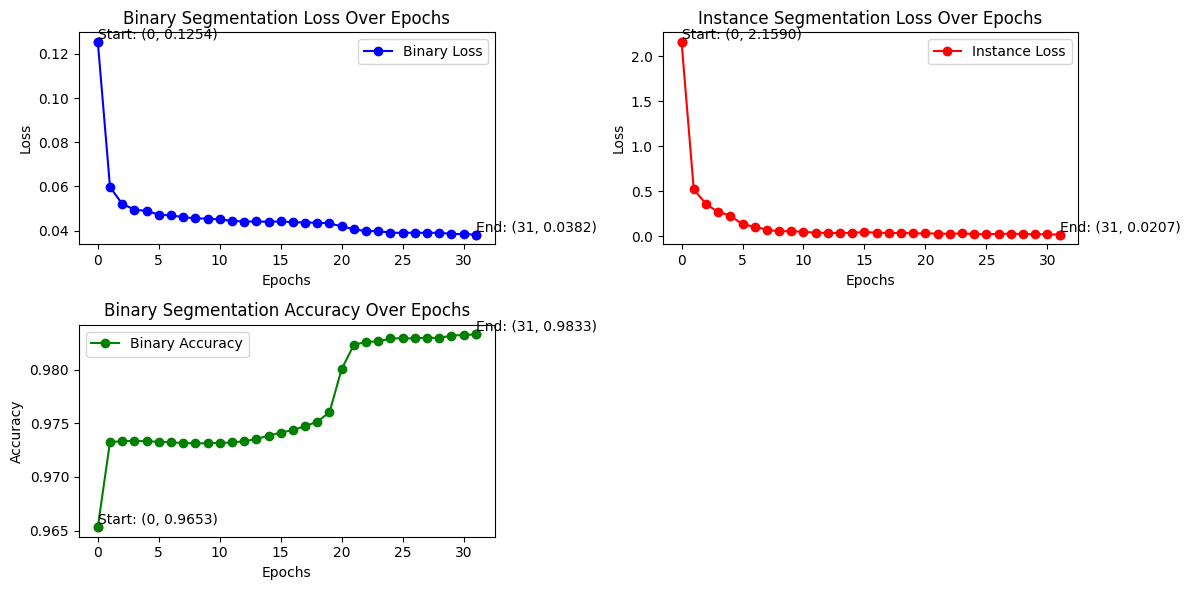

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# ... (rest of your code)

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [binary_losses_epoch[0], binary_losses_epoch[-1]], color='r', marker='o')
plt.text(0, binary_losses_epoch[0], f'Start: (0, {binary_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, binary_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {binary_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [instance_losses_epoch[0], instance_losses_epoch[-1]], color='r', marker='o')
plt.text(0, instance_losses_epoch[0], f'Start: (0, {instance_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, instance_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {instance_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [train_accuracies[0], train_accuracies[-1]], color='r', marker='o')
plt.text(0, train_accuracies[0], f'Start: (0, {train_accuracies[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, train_accuracies[-1], f'End: ({NUM_EPOCHS - 1}, {train_accuracies[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values_on_marker.png")
plt.show()


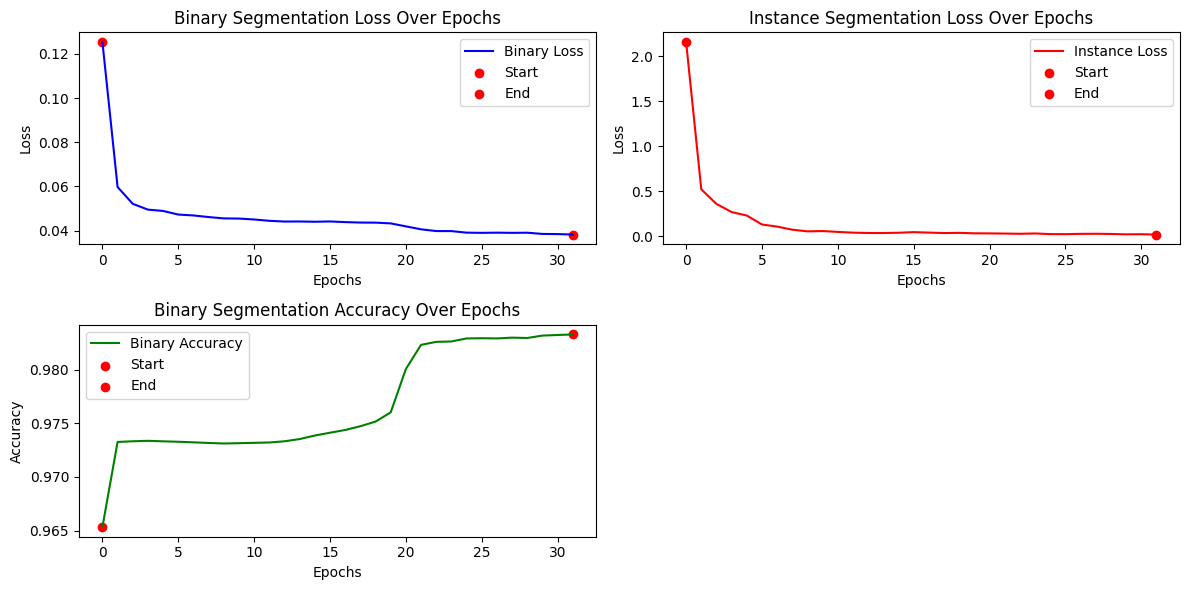

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# ... (rest of your code)

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b')
plt.scatter(0, binary_losses_epoch[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, binary_losses_epoch[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r')
plt.scatter(0, instance_losses_epoch[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, instance_losses_epoch[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g')
plt.scatter(0, train_accuracies[0], color='r', marker='o', label='Start')
plt.scatter(NUM_EPOCHS - 1, train_accuracies[-1], color='r', marker='o', label='End')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end.png")
plt.show()

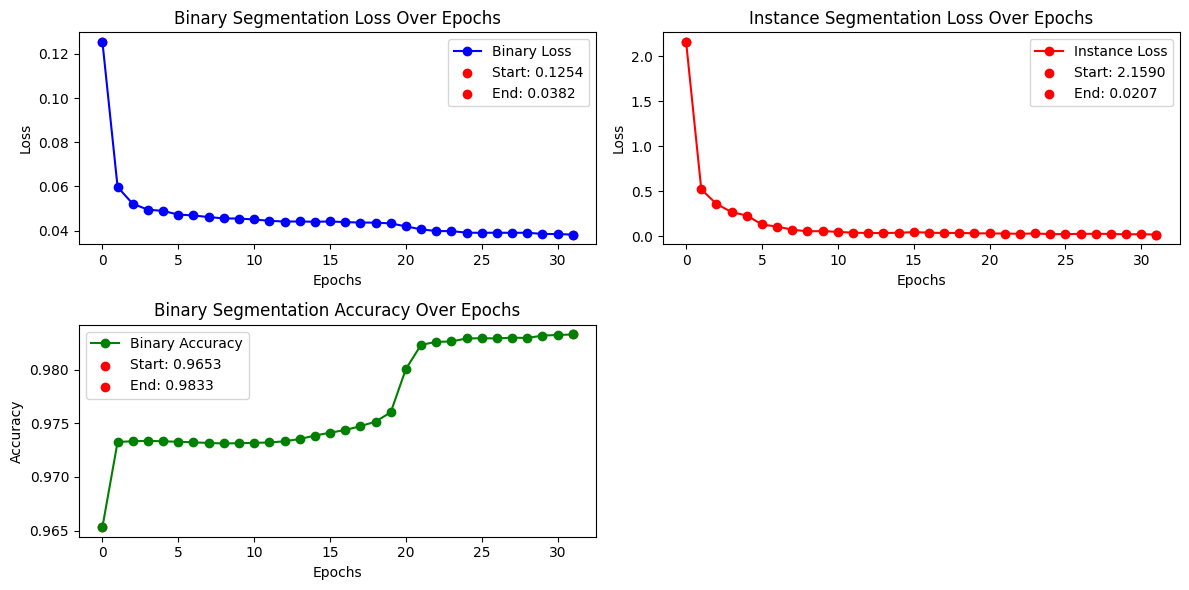

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# ... (rest of your code)

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter(0, binary_losses_epoch[0], color='r', marker='o', label=f'Start: {binary_losses_epoch[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, binary_losses_epoch[-1], color='r', marker='o', label=f'End: {binary_losses_epoch[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter(0, instance_losses_epoch[0], color='r', marker='o', label=f'Start: {instance_losses_epoch[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, instance_losses_epoch[-1], color='r', marker='o', label=f'End: {instance_losses_epoch[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter(0, train_accuracies[0], color='r', marker='o', label=f'Start: {train_accuracies[0]:.4f}')
plt.scatter(NUM_EPOCHS - 1, train_accuracies[-1], color='r', marker='o', label=f'End: {train_accuracies[-1]:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values.png")
plt.show()

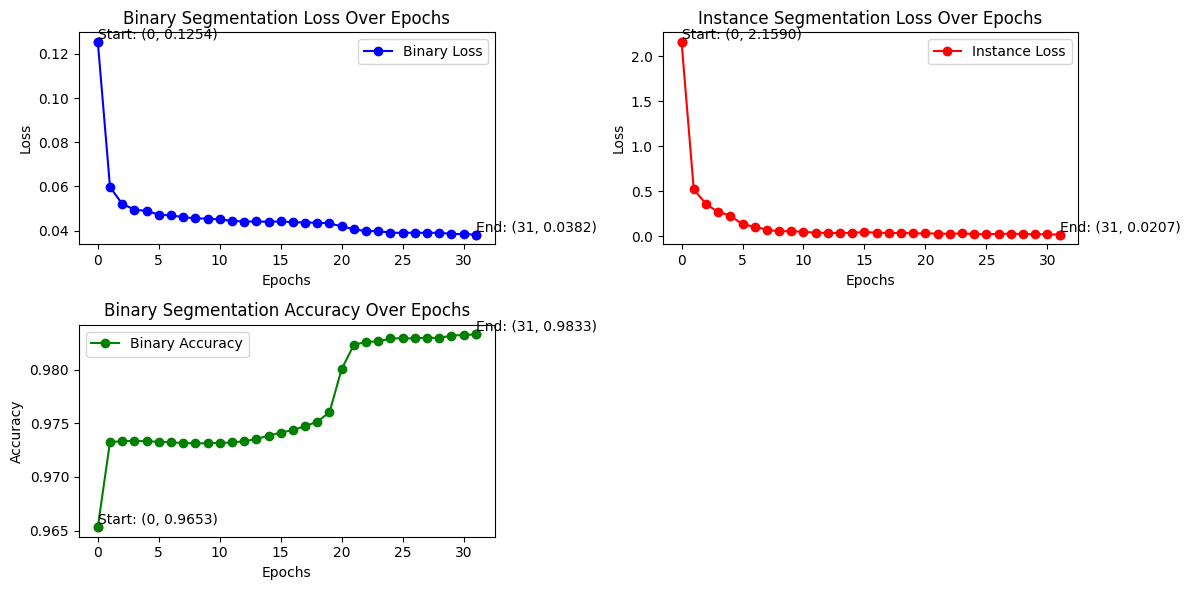

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# ... (rest of your code)

# Plot the training losses and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot Binary Segmentation Loss
plt.subplot(2, 2, 1)
plt.plot(range(NUM_EPOCHS), binary_losses_epoch, label="Binary Loss", color='b', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [binary_losses_epoch[0], binary_losses_epoch[-1]], color='r', marker='o')
plt.text(0, binary_losses_epoch[0], f'Start: (0, {binary_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, binary_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {binary_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Segmentation Loss Over Epochs')
plt.legend()

# Plot Instance Segmentation Loss
plt.subplot(2, 2, 2)
plt.plot(range(NUM_EPOCHS), instance_losses_epoch, label="Instance Loss", color='r', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [instance_losses_epoch[0], instance_losses_epoch[-1]], color='r', marker='o')
plt.text(0, instance_losses_epoch[0], f'Start: (0, {instance_losses_epoch[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, instance_losses_epoch[-1], f'End: ({NUM_EPOCHS - 1}, {instance_losses_epoch[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Instance Segmentation Loss Over Epochs')
plt.legend()

# Plot Binary Segmentation Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(NUM_EPOCHS), train_accuracies, label="Binary Accuracy", color='g', marker='o')
plt.scatter([0, NUM_EPOCHS - 1], [train_accuracies[0], train_accuracies[-1]], color='r', marker='o')
plt.text(0, train_accuracies[0], f'Start: (0, {train_accuracies[0]:.4f})', verticalalignment='bottom')
plt.text(NUM_EPOCHS - 1, train_accuracies[-1], f'End: ({NUM_EPOCHS - 1}, {train_accuracies[-1]:.4f})', verticalalignment='bottom')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Binary Segmentation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig("combined_plots_with_start_end_values_on_marker.png")
plt.show()

In [12]:
# Save the trained model
torch.save(enet_model.state_dict(), "enet_new_model.pth")

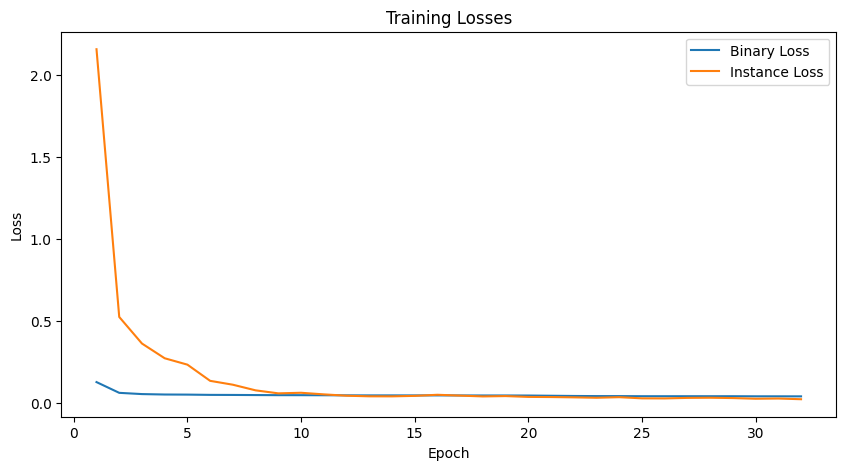

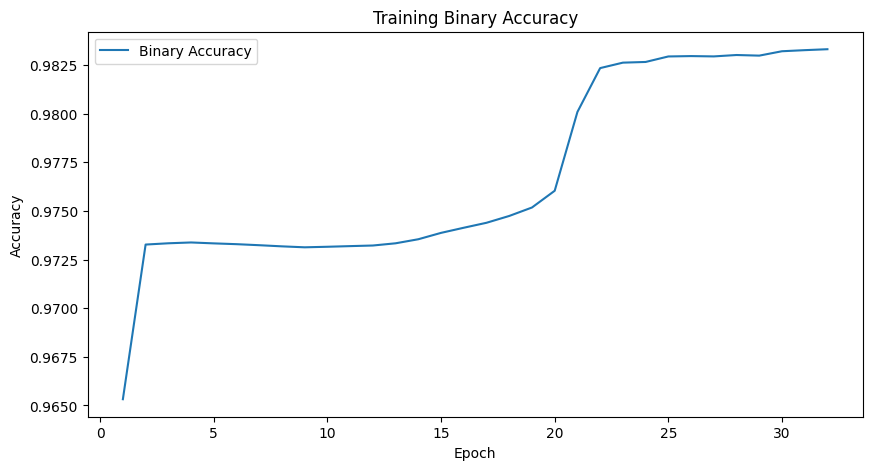

In [13]:
# Plotting training losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), binary_losses_epoch, label='Binary Loss')
plt.plot(range(1, NUM_EPOCHS + 1), instance_losses_epoch, label='Instance Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Binary Accuracy')
plt.legend()
plt.show()

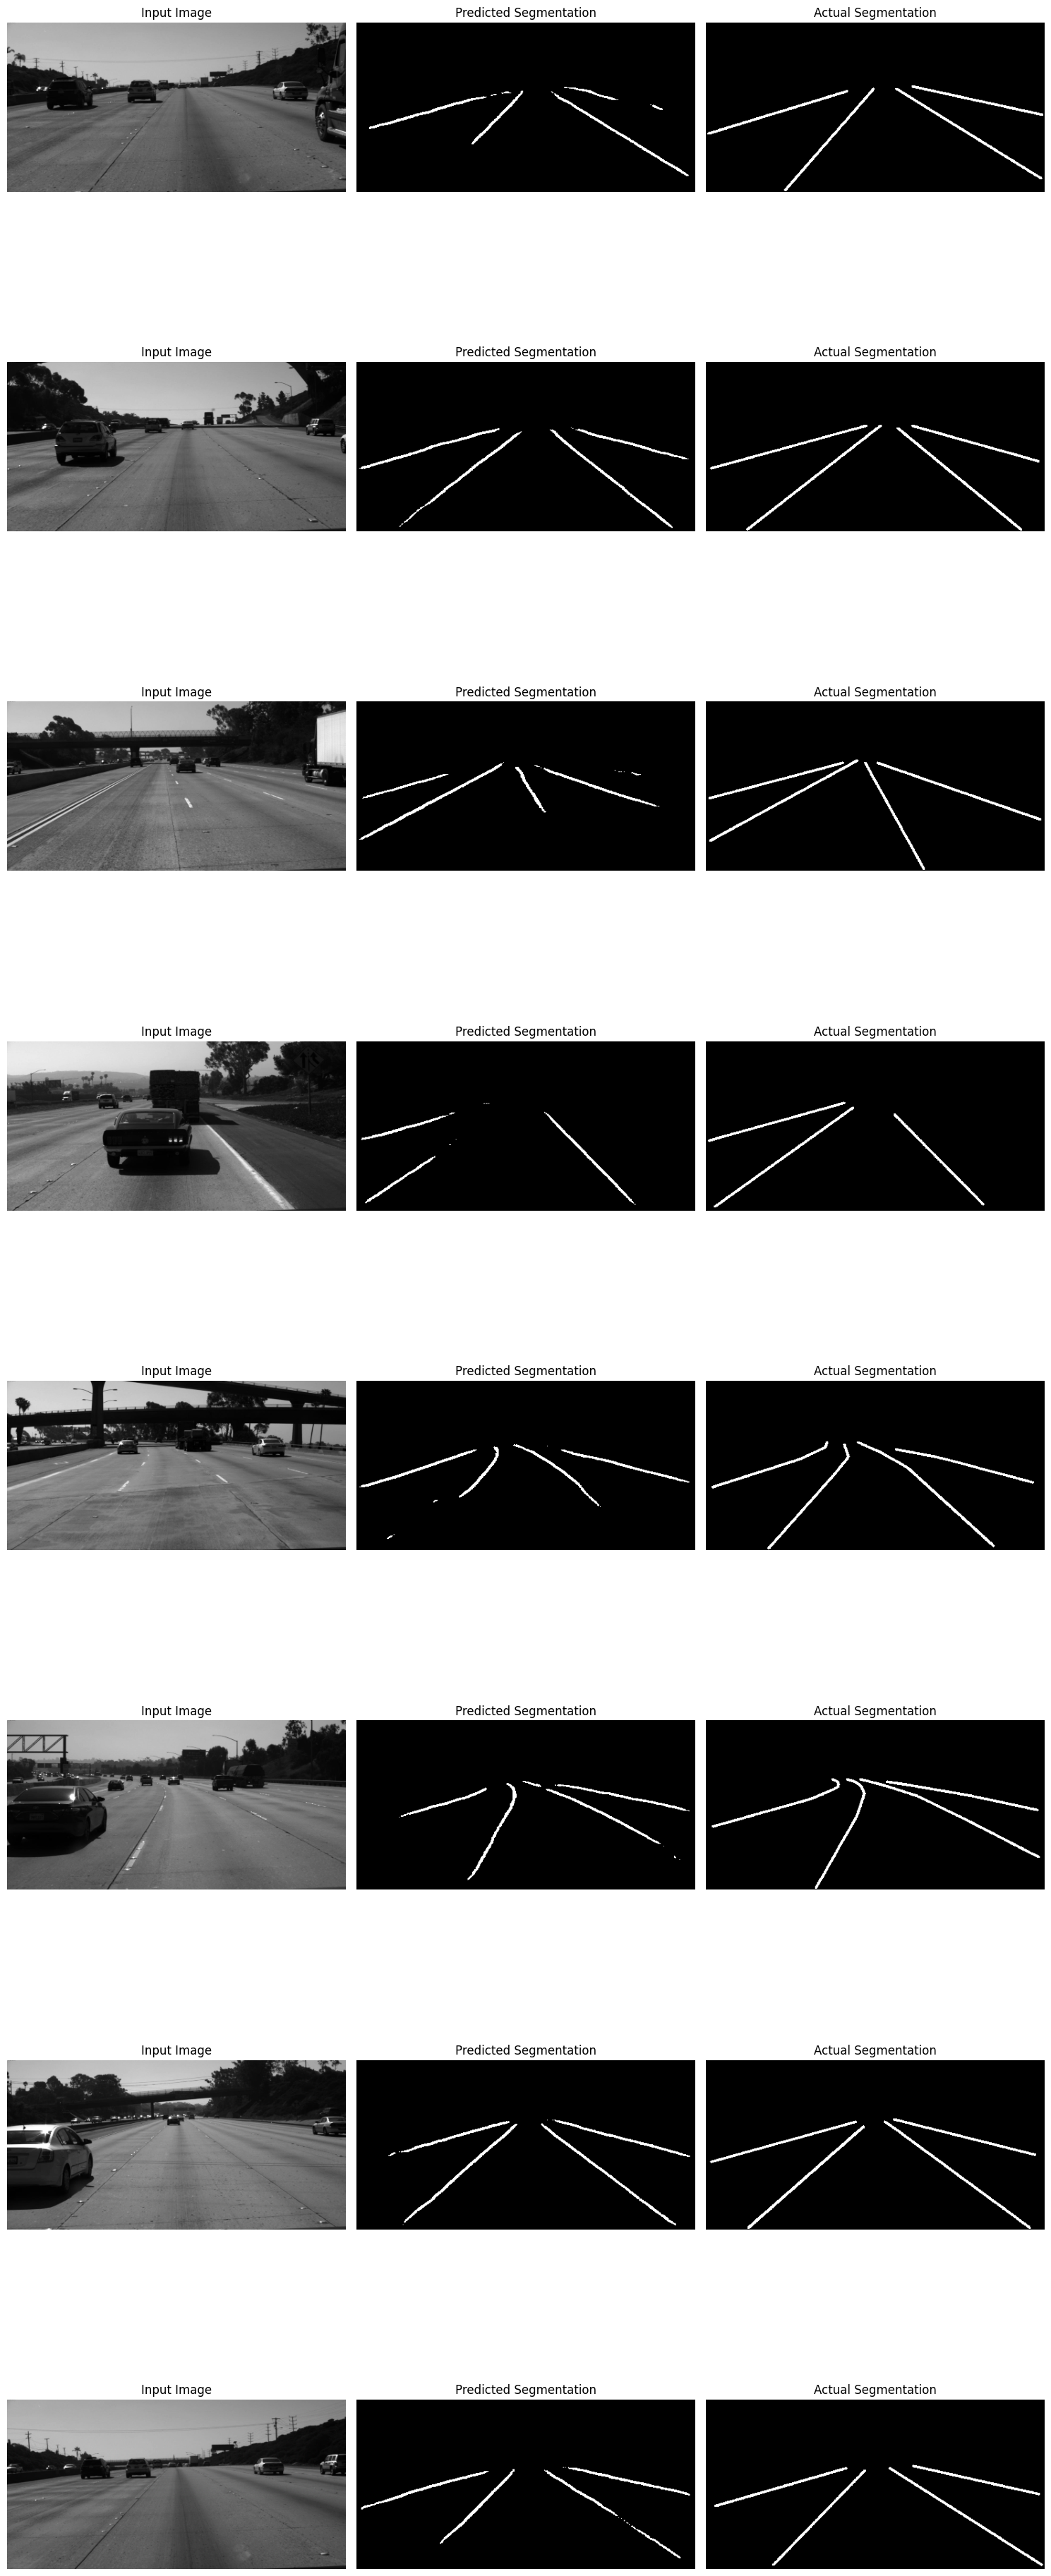

In [14]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)

        binary_logits, instance_emb = model(img)
        binary_preds = torch.argmax(binary_logits, dim=1)

        img = img.cpu().numpy()
        binary_preds = binary_preds.cpu().numpy()
        binary_target = binary_target.cpu().numpy()

        fig, axes = plt.subplots(len(img), 3, figsize=(15, 5 * len(img)))

        for i in range(len(img)):
            ax = axes[i, 0]
            ax.imshow(img[i].transpose((1, 2, 0)).squeeze(), cmap='gray')
            ax.set_title("Input Image")
            ax.axis("off")

            ax = axes[i, 1]
            ax.imshow(binary_preds[i], cmap='gray')
            ax.set_title("Predicted Segmentation")
            ax.axis("off")

            ax = axes[i, 2]
            ax.imshow(binary_target[i].squeeze(), cmap='gray')
            ax.set_title("Actual Segmentation")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Call the plotting function after the training loop
plot_predictions(enet_model, train_dataloader, device)


In [15]:
def bezier_curve(points, n_points=100):
    """
    Compute n_points on a Bezier curve defined by the given control points.
    
    Parameters:
    points (list of tuples): Control points for the Bezier curve.
    n_points (int): Number of points to generate on the curve.
    
    Returns:
    np.ndarray: Generated points on the Bezier curve.
    """
    points = np.array(points)
    n = len(points)
    binomial_coeff = np.array([np.math.comb(n - 1, i) for i in range(n)])
    
    def bezier(t):
        return np.sum([binomial_coeff[i] * (1 - t) ** (n - 1 - i) * t ** i * points[i] for i in range(n)], axis=0)
    
    return np.array([bezier(t) for t in np.linspace(0, 1, n_points)])


In [16]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path="/Users/dakshpatel/Desktop/Computer_Vision/Project/Code/TuSimple_Dataset/TUSimple/train_set", train=True, size=(512, 256)):
        self._dataset_path = dataset_path
        self._mode = "train" if train else "eval"
        self._image_size = size # w, h

        if self._mode == "train":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0313", "0531")
            ]
        elif self._mode == "eval":
            label_files = [
                os.path.join(self._dataset_path, f"label_data_{suffix}.json")
                for suffix in ("0601",)
            ]

        self._data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        image_path = os.path.join(self._dataset_path, self._data[idx][0])
        image = cv2.imread(image_path)
        h, w, c = image.shape
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self._data[idx][1]

        segmentation_image = self._draw(h, w, lanes, "segmentation")
        instance_image = self._draw(h, w, lanes, "instance")

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self._data)

    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == "segmentation" else i + 1
            # Convert lane points to a list of tuples
            lane_points = [(x, y) for x, y in lane]
            bezier_points = bezier_curve(lane_points)
            bezier_points = np.round(bezier_points).astype(int)
            for j in range(len(bezier_points) - 1):
                cv2.line(image, tuple(bezier_points[j]), tuple(bezier_points[j+1]), color, 10)
        
        image = cv2.resize(image, self._image_size, interpolation=cv2.INTER_NEAREST)

        return image

    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info["raw_file"]
                lanes = info["lanes"]
                h_samples = info["h_samples"]
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self._data.append((image, lanes_coords))


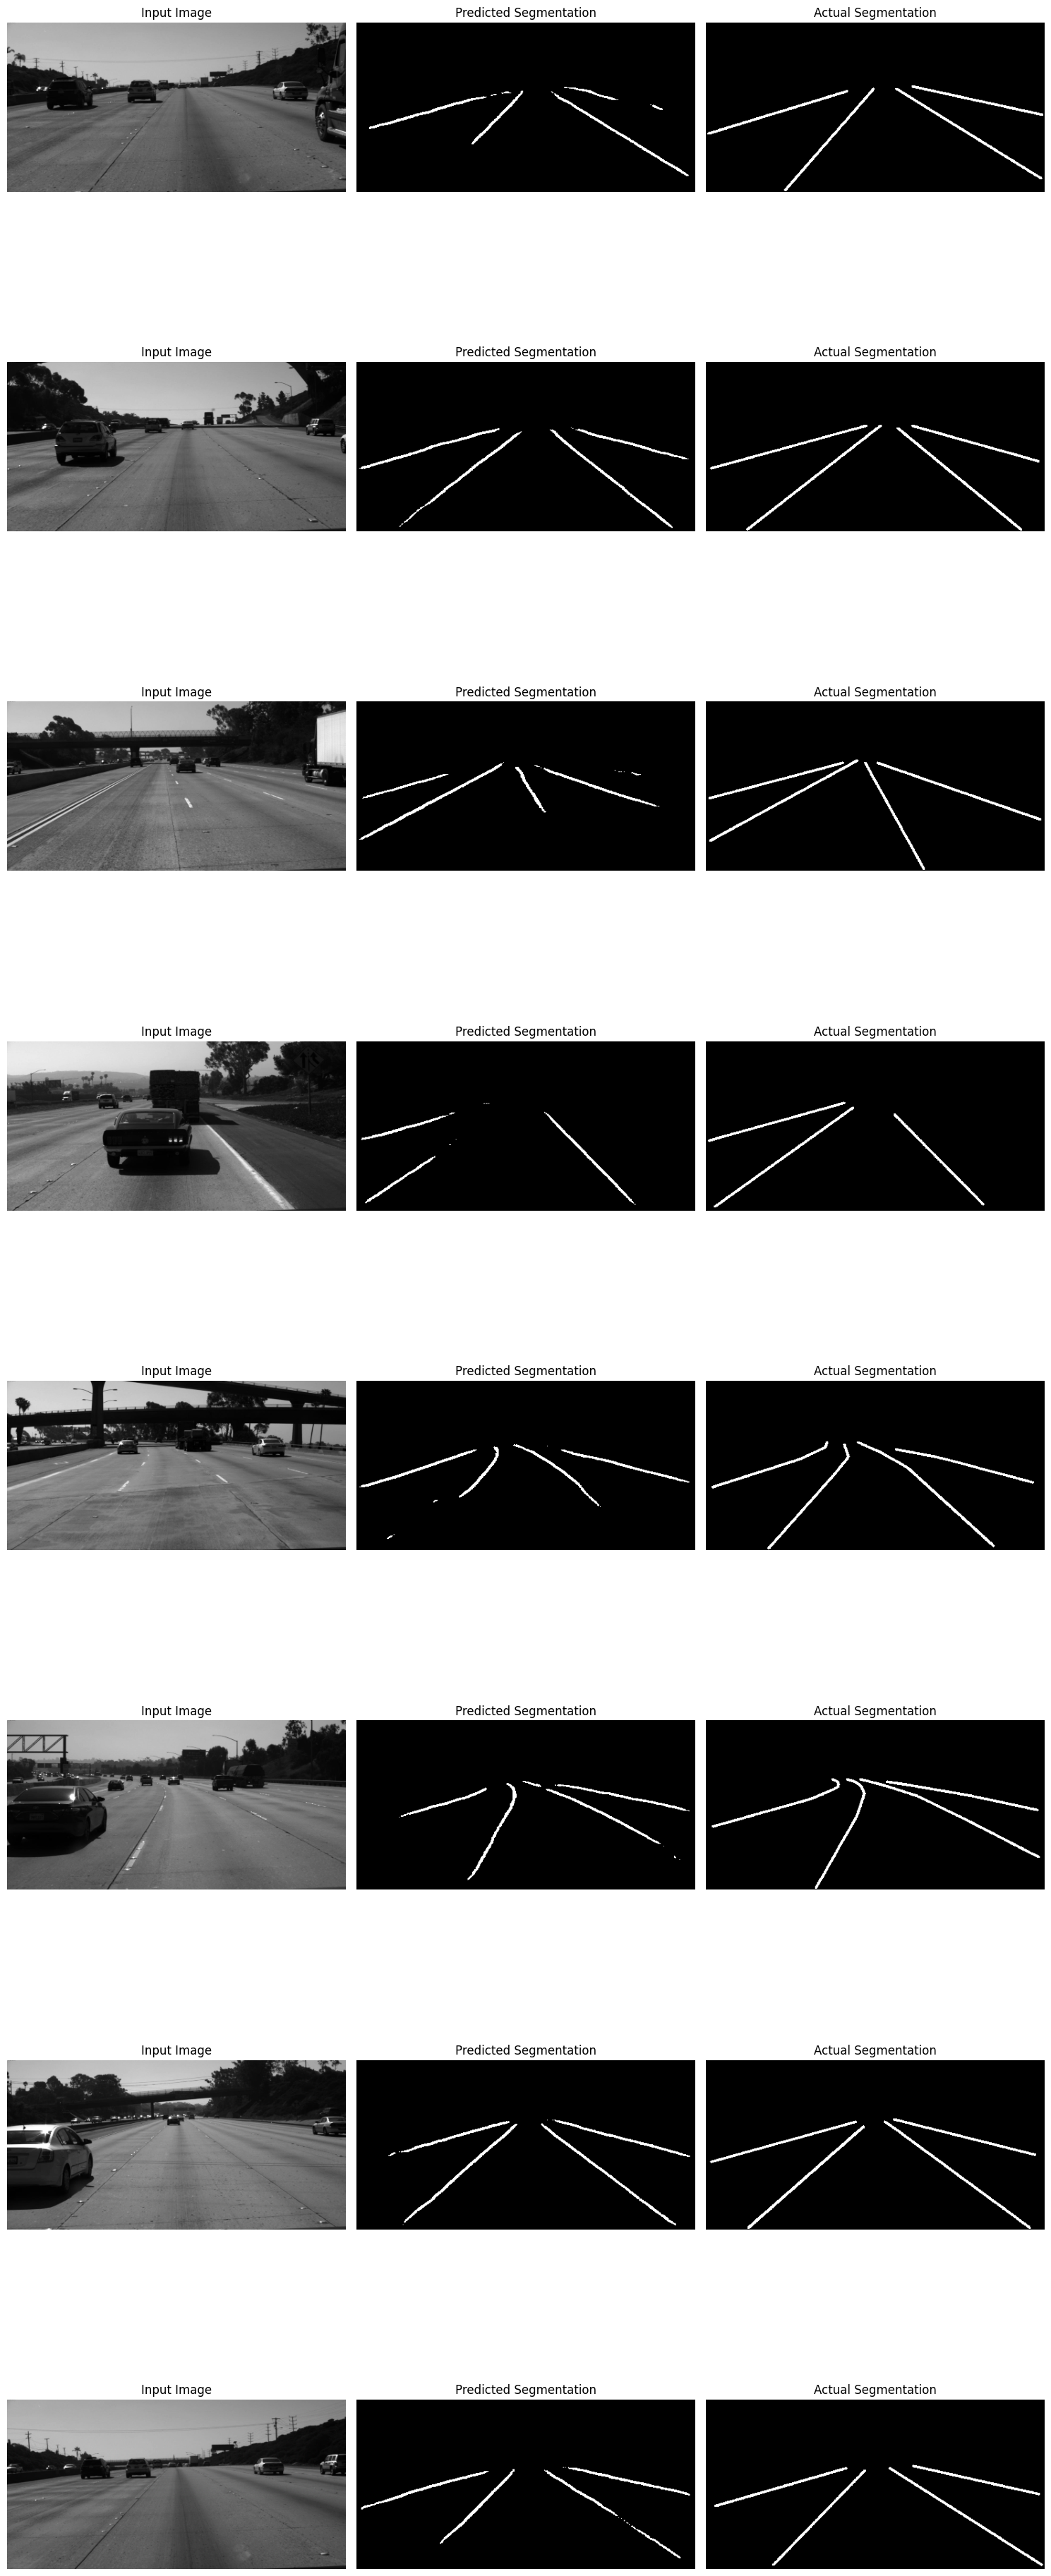

In [17]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)

        binary_logits, instance_emb = model(img)
        binary_preds = torch.argmax(binary_logits, dim=1)

        img = img.cpu().numpy()
        binary_preds = binary_preds.cpu().numpy()
        binary_target = binary_target.cpu().numpy()

        fig, axes = plt.subplots(len(img), 3, figsize=(15, 5 * len(img)))

        for i in range(len(img)):
            ax = axes[i, 0]
            ax.imshow(img[i].transpose((1, 2, 0)).squeeze(), cmap='gray')
            ax.set_title("Input Image")
            ax.axis("off")

            ax = axes[i, 1]
            ax.imshow(binary_preds[i], cmap='gray')
            ax.set_title("Predicted Segmentation")
            ax.axis("off")

            ax = axes[i, 2]
            ax.imshow(binary_target[i].squeeze(), cmap='gray')
            ax.set_title("Actual Segmentation")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

# Call the plotting function after the training loop
plot_predictions(enet_model, train_dataloader, device)


In [18]:
from sklearn.linear_model import LinearRegression
import numpy as np

def extract_lane_points(binary_segmentation):
    """
    Extract lane points from the binary segmentation image.
    
    Parameters:
    binary_segmentation (numpy.ndarray): Binary segmentation image.
    
    Returns:
    list: List of lane points (x, y).
    """
    points = np.column_stack(np.where(binary_segmentation > 0))
    return points

def fit_line_to_points(points):
    """
    Fit a line to the given points using linear regression.
    
    Parameters:
    points (list): List of lane points (x, y).
    
    Returns:
    tuple: Slope and intercept of the fitted line.
    """
    if len(points) < 2:
        return None, None  # Not enough points to fit a line
    
    x = points[:, 1].reshape(-1, 1)
    y = points[:, 0].reshape(-1, 1)
    model = LinearRegression().fit(x, y)
    slope = model.coef_[0][0]
    intercept = model.intercept_[0]
    
    return slope, intercept

def calculate_angle(slope):
    """
    Calculate the angle of the line with respect to the horizontal axis.
    
    Parameters:
    slope (float): Slope of the line.
    
    Returns:
    float: Angle in degrees.
    """
    angle_rad = np.arctan(slope)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


In [19]:
def plot_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        batch = next(iter(dataloader))
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)

        binary_logits, instance_emb = model(img)
        binary_preds = torch.argmax(binary_logits, dim=1)

        img = img.cpu().numpy()
        binary_preds = binary_preds.cpu().numpy()
        binary_target = binary_target.cpu().numpy()

        fig, axes = plt.subplots(len(img), 3, figsize=(15, 5 * len(img)))

        for i in range(len(img)):
            ax = axes[i, 0]
            ax.imshow(img[i].transpose((1, 2, 0)).squeeze(), cmap='gray')
            ax.set_title("Input Image")
            ax.axis("off")

            ax = axes[i, 1]
            ax.imshow(binary_preds[i], cmap='gray')
            ax.set_title("Predicted Segmentation")
            ax.axis("off")

            # Extract lane points and calculate angle
            points = extract_lane_points(binary_preds[i])
            slope, intercept = fit_line_to_points(points)
            if slope is not None:
                angle = calculate_angle(slope)
                ax.set_title(f"Predicted Segmentation\nAngle: {angle:.2f}°")
            else:
                ax.set_title("Predicted Segmentation\nNo lane detected")

            ax = axes[i, 2]
            ax.imshow(binary_target[i].squeeze(), cmap='gray')
            ax.set_title("Actual Segmentation")
            ax.axis("off")

        plt.tight_layout()
        plt.show()


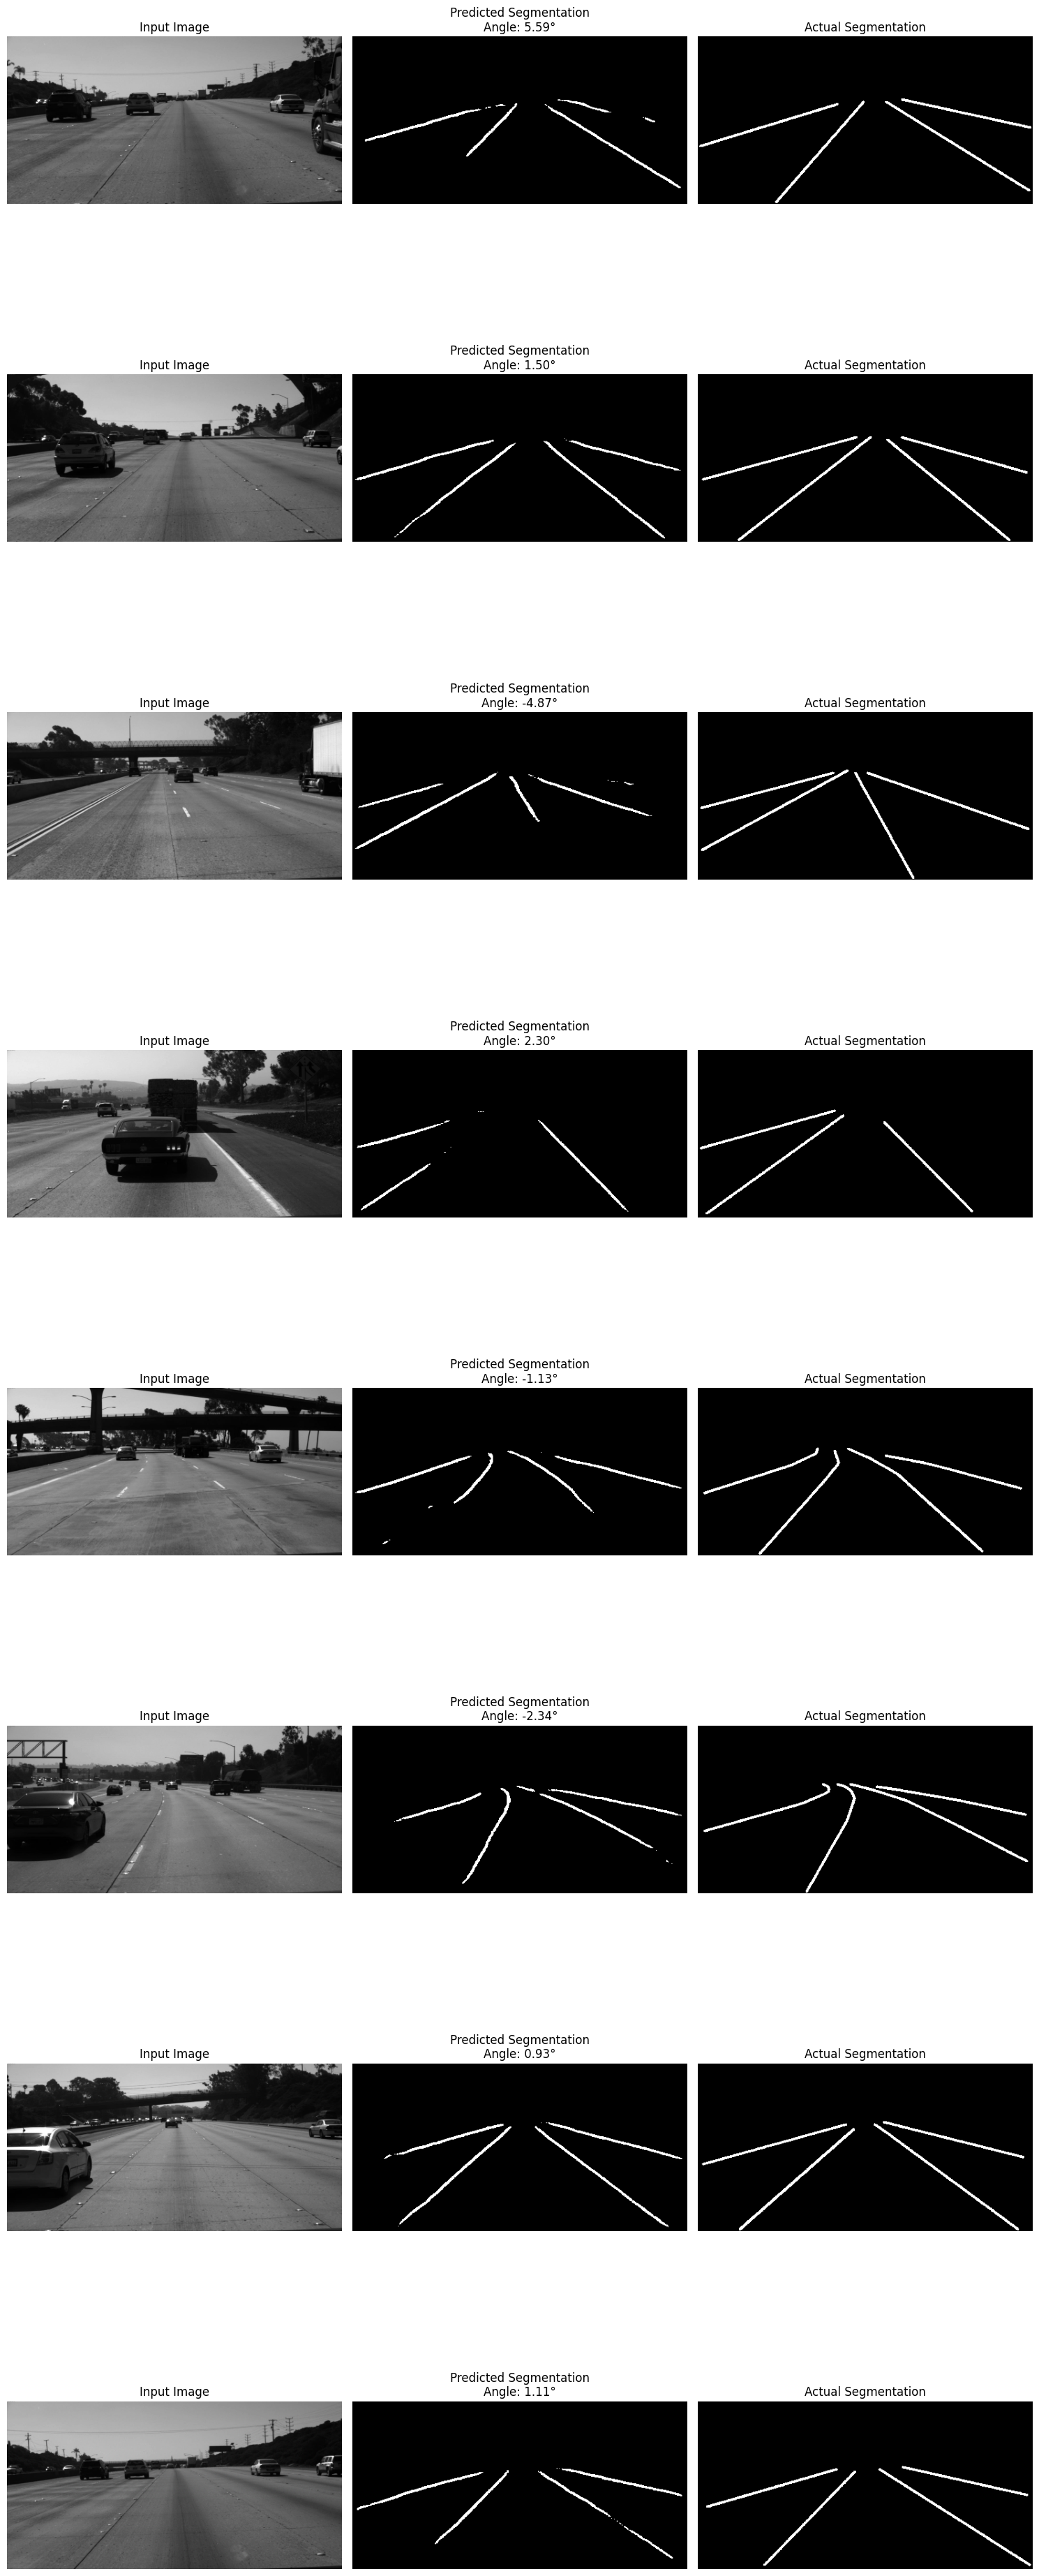

In [20]:
plot_predictions(enet_model, train_dataloader, device)